<a href="https://colab.research.google.com/github/Sejmou/ml-ex3/blob/master/notebooks/Data_Exploration_CIFAR-10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring the CIFAR-10 dataset

In this notebook we explore the [CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html) dataset and also prepare it for further processing by Machine Learning Classifiers.

The processing steps described here were also implemented in the `CIFAR10Loader` utility/helper class that can be found in `data_loaders.py` in `notebooks/helper_scripts`.

## Importing Required Libraries

In [1]:
from io import BytesIO
from zipfile import ZipFile
import requests
import csv
import math
import os
import shutil
from collections import defaultdict
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import requests
import tarfile
import os
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split


running_in_colab = 'google.colab' in str(get_ipython())
if running_in_colab:
  # unfortunately, we cannot import our helper scripts directly on Google Colab as other files from our repo are not accessible
  # we have to clone our GitHub repo to fetch the helper scripts and add the script folder of cloned repo to the syspath
  print('Notebook running on Google Colab')
  repo_path = './ml-ex3'
  repo_git_url = 'https://github.com/Sejmou/ml-ex3.git'

  import subprocess
  import sys

  def install(package):#https://stackoverflow.com/a/50255019/13727176
    print(f'Installing {package} using pip')
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])
  
  if 'git' not in sys.modules:
    install('GitPython')
  
  from git import Repo

  if os.path.exists(repo_path): # already cloned -> pull latest changes
    print('pulling from our git repo to get latest version of helper scripts')
    repo = Repo(repo_path)
    o = repo.remotes.origin
    o.pull()
    print('pulled successfully')
    import importlib
    import helper_scripts
    importlib.reload(helper_scripts)
    print('reloaded helper_scripts module')
  else:
    print('cloning our git repo to get helper scripts')
    Repo.clone_from(repo_git_url, repo_path)
    print('cloned successfully')
    sys.path.append(f'{repo_path}/notebooks')# path to folder containing helper scripts
    print('appended helper_scripts module to sys.path')

from helper_scripts.data_exploration import file_and_folder_overview, print_dataset_summary

Notebook running on Google Colab
Installing GitPython using pip
cloning our git repo to get helper scripts
cloned successfully
appended helper_scripts module to sys.path


## Download data

In [2]:
# remove unnecessary sample_data folder (present if running on Colab)
shutil.rmtree('./sample_data/', ignore_errors=True)# will fail if folder not present -> ignore error

In [3]:
archive_url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
response = requests.get(archive_url, stream=True)
file = tarfile.open(fileobj=response.raw, mode="r|gz")
file.extractall(path=".")

## Check downloaded data

In [4]:
!ls

cifar-10-batches-py  ml-ex3


Let's get an overview of the data that has been downloaded (by using our `filea_and_folder_overview` helper function:

In [5]:
file_and_folder_overview('.')

./
    cifar-10-batches-py/
        data_batch_1
        data_batch_4
        data_batch_3
        data_batch_5
        data_batch_2
        ... and 1 other .(No extension) files
        readme.html
        batches.meta
    ml-ex3/
        requirements.txt
        test.py
        model_fit_results/
            CIFAR-10/
                LeNet/
                    2022-02-21_00_01_S/
                        no_augmentation/
                            Model.h5
                            best_val_acc_weights.h5
                            fit_times.csv
                            tensorboard/
                                train/
                                    events.out.tfevents.1645401699.8b1c62b7f0cc.82.0.v2
                                validation/
                                    events.out.tfevents.1645401718.8b1c62b7f0cc.82.1.v2
                    2022-02-21_00_44_03/
                        with_augmentation/
                            best_val_acc_weights.h5
       

## Load data according to README at [dataset website](http://www.cs.toronto.edu/~kriz/cifar.html)

In [6]:
#The archive contains the files data_batch_1, data_batch_2, ..., data_batch_5, as well as test_batch.
#Each of these files is a Python "pickled" object produced with cPickle.
#Here is a python3 routine which will open such a file and return a dictionary:
def unpickle(file):
    with open(file, 'rb') as fo:
        res = pickle.load(fo, encoding='bytes')
    return res

Website also states:

>Loaded in this way, each of the batch files contains a dictionary with the following elements:
* data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
* labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

## Load images into memory

The extracted archive contains the files data_batch_1, data_batch_2, ..., data_batch_5, as well as test_batch.
Each of these files is a Python "pickled" object produced with cPickle. Let's try to load the images from those batches to obtain our train and test splits.

In [7]:
batch_filenames = glob.glob(f'./cifar-10-batches-py/*_batch*')
batch_filenames

['./cifar-10-batches-py/data_batch_1',
 './cifar-10-batches-py/data_batch_4',
 './cifar-10-batches-py/data_batch_3',
 './cifar-10-batches-py/data_batch_5',
 './cifar-10-batches-py/data_batch_2',
 './cifar-10-batches-py/test_batch']

In [8]:
test_batch_filename = next(filter(lambda filename: 'test' in filename, batch_filenames), None)
test_batch_filename

'./cifar-10-batches-py/test_batch'

In [10]:
train_batch_filenames = list(filter(lambda filename: not filename == test_batch_filename, batch_filenames))
train_batch_filenames

['./cifar-10-batches-py/data_batch_1',
 './cifar-10-batches-py/data_batch_4',
 './cifar-10-batches-py/data_batch_3',
 './cifar-10-batches-py/data_batch_5',
 './cifar-10-batches-py/data_batch_2']

In [11]:
test_batch = unpickle(test_batch_filename)
print(list(test_batch.keys()))

[b'batch_label', b'labels', b'data', b'filenames']


We notice that each unpickled file contains a dictionary with four keys (this is also mentioned on the dataset website):
 * batch_label -- describes the "name"/purpose of the batch (may be one of the 5 test batches or the single test batch)
 * data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
 * labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.
 * filenames -- a list storing the filenames of each respective image in data -> irrelevant to us!

we will need to put all the data and labels from the training batches together into NumPy arrays of shapes n x 32 x 32 x 3 and n.

Note that we therefore also need to reshape the image data and concatenate all arrays!
A similar process can be followed for the test data and labels, however we just use the single batch and don't need to concatenate.

We also notice that the keys are byte-strings, but that should not worry us.

Let's write a function for extracting the important data (the images and the labels). We will also need to reshape the image data.

In [12]:
def reshape_batch_data(batch_data):
    '''
    Reshapes the batch data from n x 3072 to n x 32 x 32 x 3
    '''

    #"problem": batch data has (is expected to have) shape n x 3072
    # * n is the number of images in the batch
    # * 3072 are the pixels of each image (1024 per channel)
    # We know that the CIFAR-10 dataset contains 32 x 32 images, and 32 x 32 happens to be exactly 1024 :)
    # our goal is to get a matrix of shape (n, 32, 32, 3), where 3 is the number of color channels
    n = batch_data.shape[0]
    res = batch_data.reshape(n, 3, 32, 32)

    # Now, we need to "reaarange" the dimensions using NumPy's transpose() - see https://numpy.org/doc/stable/reference/generated/numpy.ndarray.transpose.html#numpy.ndarray.transpose
    # i in the j-th place means res's i-th axis becomes res.transpose()'s j-th axis.
    # so, the below call gives us exactly the desired shape: (n, 32, 32, 3)!
    res = res.transpose(0,2,3,1)
    return res

def get_batch_imgs_and_labels(batch):
    # note: each batch is a dictionary, its keys are byte strings!
    data = batch.get(b'data')
    imgs = reshape_batch_data(data)
    labels = np.array(batch.get(b'labels'))
    return imgs, labels

In [13]:
test_imgs, test_labels = get_batch_imgs_and_labels(test_batch)

In [14]:
test_imgs.shape

(10000, 32, 32, 3)

In [15]:
test_labels.shape

(10000,)

In [16]:
train_batches = [unpickle(filename) for filename in train_batch_filenames]
train_imgs, train_labels = zip(*[get_batch_imgs_and_labels(batch) for batch in train_batches])
train_imgs = np.concatenate(train_imgs)
train_labels = np.concatenate(train_labels)

In [17]:
train_imgs.shape

(50000, 32, 32, 3)

In [18]:
train_labels.shape

(50000,)

We notice that the train test ratio in the provided data is 5/6 : 1/5

## Exploring The Dataset

### Identifying The Classes/Categories

How many categories are there?

In [20]:
NUM_CATEGORIES = len(np.unique(test_labels))
NUM_CATEGORIES

10

What are the categories? Let's try to find out by plotting one example image from each class:



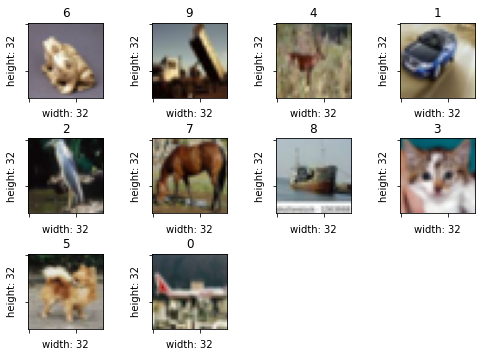

In [21]:
def get_imgs_per_class_label(imgs, labels):
  '''
  returns a dictionary (key: class label, value: list of images)
  '''
  imgs_by_class = defaultdict(list)
  for i, label in enumerate(labels):
    imgs_by_class[label].append(imgs[i])
  return imgs_by_class

# Visualizing one random image from each class (in the training set)
def plot_random_img_per_class_label(imgs_by_class):
  no_of_labels = len(imgs_by_class.keys())
  # we want to plot one image for each class in a "large enough" quadratic grid
  grid_cols = grid_rows = math.ceil(math.sqrt(no_of_labels)) 

  plt.figure(figsize=(grid_cols * 2, grid_rows * 2))
  plt.subplots_adjust(wspace=0.65, hspace=0.3)
  # iterate over dict containings lists of images  for each class
  for i, (class_label, imgs) in enumerate(imgs_by_class.items()):
    plt.subplot(grid_cols, grid_rows, i + 1)
    
    rand_img = imgs[np.random.choice(len(imgs))]
    plt.imshow(rand_img)

    ax = plt.gca()
    ax.set_title(class_label)

    # we don't need ticks
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlabel(f'width: {rand_img.shape[1]}')
    ax.set_ylabel(f'height: {rand_img.shape[0]}')

train_imgs_per_class = get_imgs_per_class_label(train_imgs, train_labels)
plot_random_img_per_class_label(train_imgs_per_class)

By looking at an example image for each class in the training set, we now know that the class IDs actually mean. Of course this is also documented in the dataset description on the dataset website. Let's store the information:

In [22]:
# mapping of numeric label to text label
text_labels = { 0:'Airplane',
            1:'Automobile', 
            2:'Bird', 
            3:'Cat', 
            4:'Deer', 
            5:'Dog', 
            6:'Frog', 
            7:'Horse', 
            8:'Ship', 
            9:'Truck'}

Let's do a quick sanity-check that the class labels are also correct for the test set.

We can map the numeric test set labels to the text labels using the dictionary we defined above and provide those labels to the plot function to check if everything is indeed correctly mapped:

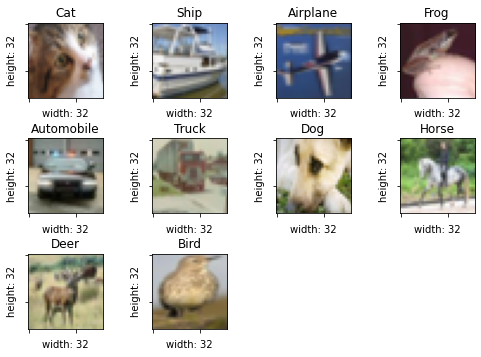

In [23]:
text_test_labels = [text_labels[int(label)] for label in test_labels]

test_imgs_per_text_label = get_imgs_per_class_label(test_imgs, text_test_labels)

plot_random_img_per_class_label(test_imgs_per_text_label)

Looks good!

### Check Class Distributions for Train and Test Set

In [33]:
def get_img_class_counts(imgs_per_class_label):
  labels = list(imgs_per_class_label.keys())
  img_counts = [len(imgs_per_class_label[label]) for label in labels]
  label_freqs = pd.DataFrame({'Label': labels, 'Count': img_counts})
  return label_freqs.sort_values('Count')

def plot_img_class_counts(img_class_counts):
  img_class_counts.plot.bar(x='Label', y='Count',
                            figsize=(img_class_counts.shape[0], img_class_counts.shape[0]/1.5))
  #plt.xticks(class_num, rotation='vertical')

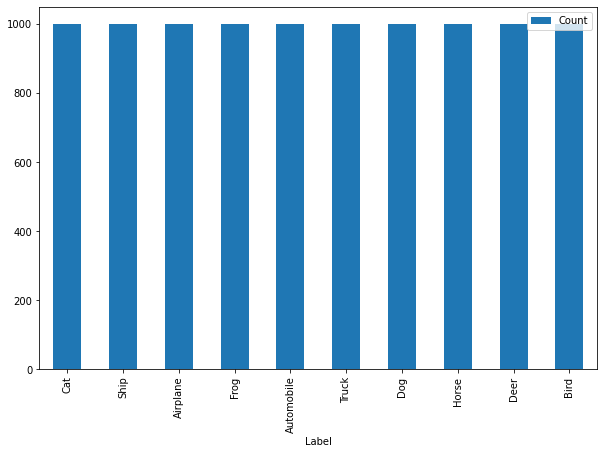

In [34]:
test_img_class_counts = get_img_class_counts(test_imgs_per_text_label)
plot_img_class_counts(test_img_class_counts)

Apparently the classes are perfectly equally distributed?

In [28]:
test_img_class_counts

,Label,Count
0,Cat,1000
1,Ship,1000
2,Airplane,1000
3,Frog,1000
4,Automobile,1000
5,Truck,1000
6,Dog,1000
7,Horse,1000
8,Deer,1000
9,Bird,1000


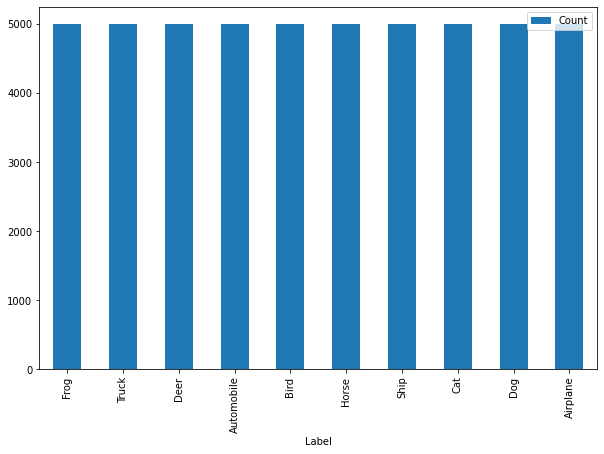

In [35]:
text_train_labels = [text_labels[int(label)] for label in train_labels]
train_imgs_per_text_label = get_imgs_per_class_label(train_imgs, text_train_labels)
train_img_class_counts = get_img_class_counts(train_imgs_per_text_label)
plot_img_class_counts(train_img_class_counts)


Are the relative class frequencies equally distributed between the training and test splits?

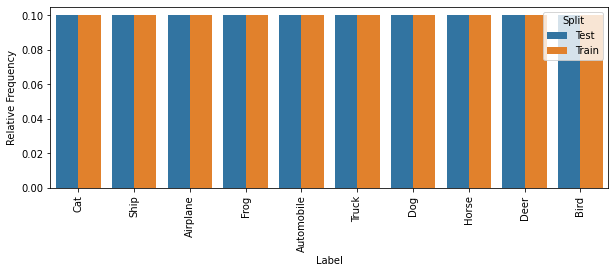

In [36]:
def get_class_freqs(img_class_counts):
  cpy = img_class_counts.copy()
  cpy.columns = ['Label','Relative Frequency']
  cpy['Relative Frequency'] = cpy['Relative Frequency']/cpy['Relative Frequency'].sum()
  return cpy

train_class_freqs = get_class_freqs(train_img_class_counts)
train_class_freqs['Split'] = 'Train'
test_class_freqs = get_class_freqs(test_img_class_counts)
test_class_freqs['Split'] = 'Test'

dataset_class_freqs = pd.concat([test_class_freqs, train_class_freqs])
plt.figure(figsize=(dataset_class_freqs.shape[0]/2, dataset_class_freqs.shape[0]/6))
plt.xticks(rotation=90)
sns.barplot(x='Label', y='Relative Frequency', hue='Split',
            data=dataset_class_freqs)

Of course, the answer is yes!

## Preparing The Data for Classification

What is the value range of the images?

In [37]:
max([img.max() for img in train_imgs])

255

In [38]:
min([img.min() for img in train_imgs])

0

The color values of the images range from 0 to 255. We should also normalize them to the [0, 1] range (by dividing by 255)

In [39]:
def normalize_imgs(imgs):
  imgs_processed= imgs/255
  return imgs_processed

In [40]:
train_imgs_processed = normalize_imgs(train_imgs)
test_imgs_processed = normalize_imgs(test_imgs)

In [41]:
train_imgs_processed.shape

(50000, 32, 32, 3)

In [42]:
test_imgs_processed.shape

(10000, 32, 32, 3)

Let's summarize the dataset once more:

In [43]:
count_test = test_imgs_processed.shape[0]
count_train = train_imgs_processed.shape[0]

train_perc = round(count_test/(count_test + count_train), 2)
f'{count_test + count_train} imgs in dataset, train/test ratio is {train_perc}:{1-train_perc}'

'60000 imgs in dataset, train/test ratio is 0.17:0.83'

As mentioned above, those processing steps outlined here were also implemented for our custom dataset loader `CIFAR10Loader`. For details on what it does additionally, see `notebooks/helper_scripts/data_loaders.py`. 